In [1]:
import os
import cv2
import time
import torch
import copy
import random

import torchvision
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from sklearn import metrics
import matplotlib.pyplot as plt

import albumentations as A
from torchvision import models
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2

torch.cuda.empty_cache()
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
torch.cuda.cudnn_enabled = False
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# os.environ["CUBLAS_WORKSPACE_CONFIG"] = ':16:8'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class_dict = {'detergent-color': 0,
 'detergent-white': 1,
 'detergent-transparent': 2,
 'detergent-box': 3,
 'juice-cardboard': 4,
 'milk-cardboard': 5,
 'cans': 6,
 'canister': 7,
 'bottle-blue': 8,
 'bottle-green-full': 9,
 'bottle-dark': 10,
 'bottle-oil-full': 11,
 'bottle-transp': 12,
 'bottle-multicolor': 13,
 'bottle-oil': 14,
 'bottle-multicolorv-full': 15,
 'bottle-milk': 16,
 'bottle-milk-full': 17,
 'bottle-green': 18,
 'bottle-blue-full': 19,
 'glass-transp': 20,
 'bottle-blue5l': 21,
 'bottle-transp-full': 22,
 'bottle-yogurt': 23,
 'bottle-blue5l-full': 24,
 'glass-green': 25,
 'glass-dark': 26,
 'bottle-dark-full': 27}

In [3]:
def path_n_dict(root):
    test_path = []
    test_label = [] 
    val_path = []
    val_label = [] 
    train_path = []
    train_label = [] 
    for k in os.listdir(root):
        big_class = os.path.join(root,k)
        for i in os.listdir(big_class):
            num_label = class_dict[i]
            per_class_path = os.path.join(big_class,i)
            for j in os.listdir(per_class_path):
                if num_label in [7,9,11,13,15,17,19]:
                    test_path.append(os.path.join(per_class_path,j)) 
                    test_label.append(num_label)
                elif num_label in [0,2,4,6,8,10,12]:
                    val_path.append(os.path.join(per_class_path,j)) 
                    val_label.append(num_label)
                else:
                    train_path.append(os.path.join(per_class_path,j)) 
                    train_label.append(num_label)
    a = list(set(train_label))
    train_label = [a.index(i) for i in train_label]
    a = list(set(val_label))
    val_label = [a.index(i) for i in val_label]
    a = list(set(test_label))
    test_label = [a.index(i) for i in test_label]
    return train_path,train_label,val_path,val_label,test_path,test_label

In [4]:
class ChoiceSample:
    def __init__(self,labels,choice_class,sample,iters):
        self.labels = labels
        self.choice_class = choice_class
        self.sample_per_class = sample
        self.iters = iters
        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)
        
        self.idxs = range(len(self.labels))
        self.indexes = np.empty((len(self.classes), max(self.counts)), dtype=int) * np.nan
        self.indexes = torch.Tensor(self.indexes)
        for idx, label in enumerate(self.labels):
            self.indexes[label, (np.isnan(self.indexes[label]).nonzero())[0][0]] = idx
            
    def __iter__(self):
        spc = self.sample_per_class
        cpi = self.choice_class
        
        for it in range(self.iters):
            batch_size = spc * cpi
            batch = torch.LongTensor(batch_size)
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, c in enumerate(self.classes[c_idxs]):
                s = slice(i * spc, (i + 1) * spc)
                sample_idxs = torch.randperm(self.counts[c])[:spc]
                batch[s] = self.indexes[c][sample_idxs]
            batch = batch[torch.randperm(len(batch))]
            yield batch
    def __len__(self):
        return self.iters

In [5]:
class MyDataset(Dataset):
    def __init__(self,path,label,transforms = None):
        self.path_image = path
        self.labels = label
        self.transforms = transforms
    def __len__(self):
        return len(self.labels)
    def __getitem__(self,idx):
        image = cv2.imread(self.path_image[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        if self.transforms:
            image = self.transforms(image = image)
        return image,label

In [6]:
size = 300
data_transforms = {
    'train': A.Compose(
    [   
        A.LongestMaxSize(max_size=size,interpolation = 2),
        A.PadIfNeeded(min_height=size, min_width=size),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.8),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.CoarseDropout(max_holes=40, max_height=16, max_width=16, always_apply=True),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
),
    'val': A.Compose(
    [   
        A.LongestMaxSize(max_size=size,interpolation = 2),
        A.PadIfNeeded(min_height=size, min_width=size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}

train_path,train_label,val_path,val_label,test_path,test_label = path_n_dict('/kaggle/input/warp-waste-recycling-plant-dataset/Warp-C/train_crops')

train_dataset = MyDataset(train_path,train_label,transforms = data_transforms["train"])
val_dataset = MyDataset(val_path,val_label,transforms = data_transforms["val"])
test_dataset = MyDataset(test_path,test_label,transforms = data_transforms["val"])

g = torch.Generator()
g.manual_seed(42)

train_sample = 20
test_sample = 20
train_class = 5
test_class = 5
iters = 200
support_sample = 5

tr_sampler = ChoiceSample(train_label,choice_class = train_class,sample=train_sample,iters=iters)
val_sampler = ChoiceSample(val_label,choice_class = test_class,sample=test_sample,iters=iters)
test_sampler = ChoiceSample(test_label,choice_class = test_class,sample =test_sample,iters=iters)

train_loader = DataLoader(train_dataset,batch_sampler = tr_sampler,generator = g)
val_loader = DataLoader(val_dataset,batch_sampler = val_sampler,generator = g)
test_loader = DataLoader(test_dataset,batch_sampler = test_sampler,generator = g)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
base_model = models.convnext_tiny(weights='IMAGENET1K_V1')
#base_model = models.efficientnet_b1()
base_model = nn.DataParallel(base_model)
base_model.to(device)
optimizer = torch.optim.AdamW(base_model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'max',patience = 2,factor = 0.5)

Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 230MB/s]  


In [9]:
def prototypical_loss(input, target, n_support):
    input = input.to(device)
    target = target.to(device)

    classes = torch.unique(target)
    n_classes = len(classes)
    def supp_idxs(c):
        return target.eq(c).nonzero()[:n_support]
    def qer_idxs(c):
        return target.eq(c).nonzero()[n_support:]
    sup_idx = list(map(supp_idxs,classes))
    prototypes = torch.stack([input[idx_list].mean(0) for idx_list in sup_idx]).squeeze(1)
    query_idx = torch.stack(list(map(qer_idxs,classes))).view(-1)
    n_query = query_idx.size(0) // n_classes
    
    query_sample = input.to(device)[query_idx]
    dists = torch.cdist(query_sample,prototypes)
    log_p_y = nn.functional.log_softmax(-dists, dim=1)
    
    target_inds = (torch.arange(0, n_classes)).to(device)
    target_inds = torch.cat([target_inds for i in range(n_query)])
    target_inds,_ = target_inds.sort()
    _, y_hat = log_p_y.max(1)
    acc_val = y_hat.eq(target_inds).float().mean()
    target_inds = target_inds.unsqueeze(1)
    loss_val = -log_p_y.gather(1, target_inds).squeeze().mean()

    return loss_val, acc_val

In [10]:
def train(model,optimizer,scheduler,epochs,resume_train = False,PATH = None):
    if resume_train:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch = None
    best_acc = 0.0
    val_loss = 1000.0
    t_list_loss = []
    t_list_acc = []
    v_list_loss = []
        
    v_list_acc = []
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0

        val_loss = 0.0
        val_acc = 0.0

        for i,(inputs,labels) in enumerate(train_loader):
            inputs = inputs['image']
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss,acc = prototypical_loss(outputs,labels,support_sample)
            loss.backward()

            optimizer.step()

            train_loss += loss.item()
            train_acc += acc.item()


        with torch.no_grad():
            model.eval()
            for i,(inputs,labels) in enumerate(val_loader):
                inputs = inputs['image']
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss,acc = prototypical_loss(outputs,labels,support_sample)

                val_loss += loss.item()
                val_acc += acc.item()

        train_loss = train_loss/iters
        train_acc = train_acc/iters

        val_loss = val_loss/iters
        val_acc = val_acc/iters

        t_list_loss.append(train_loss)
        t_list_acc.append(train_acc)
        v_list_loss.append(val_loss)
        v_list_acc.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} ')
        scheduler.step(val_acc)

        if ((val_acc>best_acc) or ((val_acc==best_acc) and (val_loss<best_loss))) :
            best_acc = val_acc
            best_epoch = epoch+1
            best_model_wts = copy.deepcopy(model.state_dict())
            best_loss = val_loss

    total_time = time.time() - start
    print(f'Training complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    print(f'Best val Epoch: {best_epoch:4f}')
    print(f'Val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model,t_list_loss,t_list_acc,v_list_loss,v_list_acc

In [11]:
epochs = 40
model_trained,t_list_loss,t_list_acc,v_list_loss,v_list_acc = train(base_model,
                                                                    optimizer,
                                                                    scheduler,
                                                                    epochs,
                                                                    resume_train = False,
                                                                    PATH='/kaggle/input/model-loader/model_b5.pt')
torch.save({'model_state_dict': model_trained.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
           },'/kaggle/working/mode l_b5_1.pt')

Epoch: 1/40
Train Loss: 0.8266 Acc: 0.6538
Val Loss: 0.9749 Acc: 0.5976 
Epoch: 2/40
Train Loss: 0.5893 Acc: 0.7538
Val Loss: 1.0347 Acc: 0.5798 
Epoch: 3/40
Train Loss: 0.4938 Acc: 0.8024
Val Loss: 0.9187 Acc: 0.6391 
Epoch: 4/40
Train Loss: 0.4343 Acc: 0.8285
Val Loss: 0.9807 Acc: 0.5981 
Epoch: 5/40
Train Loss: 0.4022 Acc: 0.8405
Val Loss: 0.8650 Acc: 0.6452 
Epoch: 6/40
Train Loss: 0.3807 Acc: 0.8491
Val Loss: 0.9512 Acc: 0.6156 
Epoch: 7/40
Train Loss: 0.3444 Acc: 0.8663
Val Loss: 0.8876 Acc: 0.6406 
Epoch: 8/40
Train Loss: 0.3239 Acc: 0.8721
Val Loss: 0.9183 Acc: 0.6308 
Epoch: 9/40
Train Loss: 0.3379 Acc: 0.8725
Val Loss: 0.8261 Acc: 0.6808 
Epoch: 10/40
Train Loss: 0.3204 Acc: 0.8745
Val Loss: 0.9251 Acc: 0.6450 
Epoch: 11/40
Train Loss: 0.2905 Acc: 0.8862
Val Loss: 0.8699 Acc: 0.6428 
Epoch: 12/40
Train Loss: 0.2823 Acc: 0.8927
Val Loss: 0.8042 Acc: 0.6644 
Epoch: 13/40
Train Loss: 0.2969 Acc: 0.8823
Val Loss: 0.9136 Acc: 0.6345 
Epoch: 14/40
Train Loss: 0.2630 Acc: 0.8987
Val

In [12]:
def cov_2_np(the_list):
  new_list = []
  for i in the_list:
    new_list.append(i)
  return new_list
t_list_acc = cov_2_np(t_list_acc)
v_list_acc = cov_2_np(v_list_acc)

In [13]:
v_list_loss

[0.9748700127005577,
 1.0347026446461678,
 0.918712028414011,
 0.9807415860891342,
 0.8650189226865769,
 0.9512363401055336,
 0.887551377415657,
 0.9182761023938656,
 0.8260911922156811,
 0.9251296502351761,
 0.8699248145520687,
 0.804210855960846,
 0.9135694824159145,
 1.0031165710091592,
 0.8629809159040451,
 0.823643932044506,
 0.9088132400810719,
 0.8373970831930637,
 0.8472480230033398,
 0.8102561569213867,
 0.8114980363845825,
 0.8312584394216538,
 0.8455307693779468,
 0.8497295194864273,
 0.8527287894487381,
 0.8876804430782795,
 0.8767549668252468,
 0.8544456768035888,
 0.86008221372962,
 0.8849220044910908,
 0.8510429239273072,
 0.8873368068784475,
 0.8250445993244648,
 0.868161931335926,
 0.8943034707009793,
 0.844463892430067,
 0.8779913957417012,
 0.8847191166877747,
 0.8544601975381374,
 0.8928146186470985]

Text(0.5, 0.98, 'Valid')

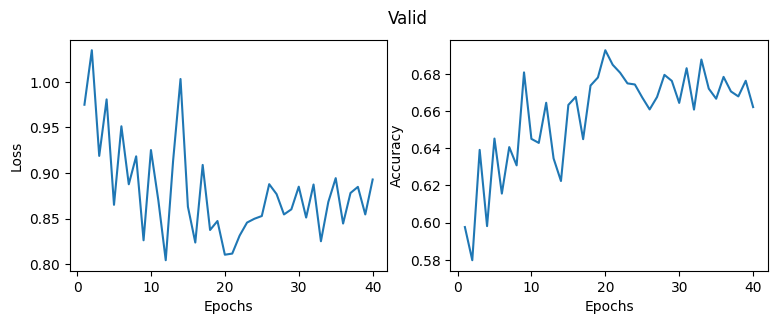

In [14]:
def visualize(metric):
  horizontal = np.arange(1,len(metric)+1,1)
  plt.plot(horizontal,metric)
# t_list_loss,t_list_acc,v_list_loss,v_list_acc
plt.figure(figsize=(9, 3))
# plt.subplot(121)
# visualize(t_list_loss)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
plt.subplot(121)
visualize(v_list_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.subplot(122)
# visualize(t_list_acc)
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.suptitle('Train')
plt.subplot(122)
visualize(v_list_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.suptitle('Valid')

In [15]:
def test(model):
    start = time.time()
    y_ = []
    y = []
    with torch.no_grad():
        model.eval()
        test_loss = 0.0
        test_acc = 0.0
        for i,(inputs,labels) in enumerate(test_loader):
                inputs = inputs['image']
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss,acc = prototypical_loss(outputs,labels,support_sample)

                test_loss += loss.item()
                test_acc += acc.item()
        test_loss = test_loss/iters
        test_acc = test_acc/iters
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    total_time = time.time() - start
    print(f'Testing complete in {total_time // 60:.0f}m {total_time % 60:.0f}s')
    return y,y_

In [16]:
true_label, predict_label = test(base_model)

Test Loss: 0.6239 Acc: 0.7770
Testing complete in 2m 14s


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:148: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:148: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)


ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 640x480 with 0 Axes>

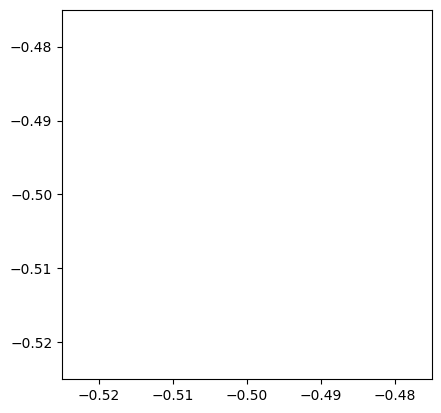

In [17]:
confusion_matrix = metrics.confusion_matrix(true_label, predict_label)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
plt.subplots_adjust(bottom=0.2)
cm_display.plot(cmap = 'Blues')
plt.show()